# VisionTech Solutions – Urban Wildlife & Vehicle Detection System

## Overview

VisionTech Solutions is developing an automated image recognition system designed to distinguish between vehicles and animals in urban environments. The primary goal is to enhance road safety by monitoring urban wildlife in real time, helping to prevent accidents, and protecting both drivers and animals.

In collaboration with municipal administrations, VisionTech will deploy a network of roadside cameras to detect and classify vehicles and animals. Real-time alerts will be displayed through electronic road signs, warning drivers of potential hazards due to unexpected animal crossings.

## Key Benefits

🔄 Automated Monitoring
Real-time detection of animals and vehicles.
Reduced need for manual surveillance and intervention.
🎯 High Accuracy
Leveraging Convolutional Neural Networks (CNNs) for precise image classification.
Minimization of human error through automated decision-making.
⚡ Operational Efficiency
Fast and scalable processing of large volumes of visual data.
Improved incident response and urban traffic safety.
🔍 Multiple Applications
Traffic surveillance and analysis.
Study of animal behavior in urban areas.
Data-driven policy making for road safety improvements.
Project Details

📂 Dataset
Utilizes the CIFAR dataset, containing thousands of labeled images across multiple categories, including animals and vehicles.
🤖 Algorithm
Implementation of a Convolutional Neural Network (CNN) to analyze and classify input images into "vehicle" or "animal".
📤 Output
The system will accurately classify each image as either a vehicle or an animal.
Model Evaluation

📊 Metrics
Accuracy: Percentage of correctly classified images.
Precision: Proportion of true positives among predicted positives.
🔎 Result Analysis
Identification of patterns in classification errors.
Review of commonly confused image categories.
Visual inspection of misclassified images to inform model improvement strategies.
Final Outcome

### The final solution will demonstrate:

The effective use of CNNs in distinguishing between vehicles and animals.
A detailed performance evaluation using standard classification metrics.
Critical insights into the system's strengths and areas for improvement.
Impact

This project offers a practical application of machine learning in real-world safety scenarios. It supports VisionTech Solutions' mission to provide smart, scalable solutions for urban wildlife management and road safety enhancement.

### Introduction
Let's start the project by downloading the necessary libraries for visualization and CNN model building.


In [ ]:
import warnings
warnings.filterwarnings("ignore")
## Import libraries
import pickle as cPickle
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, array_to_img,img_to_array
from tensorflow.keras.applications import resnet50, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import precision_score, confusion_matrix, classification_report
import seaborn as sns

### Dataset CIFAR-10

Now let's download the dataset. For more information, please  refer to the official page: https://www.cs.toronto.edu/~kriz/cifar.html



In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

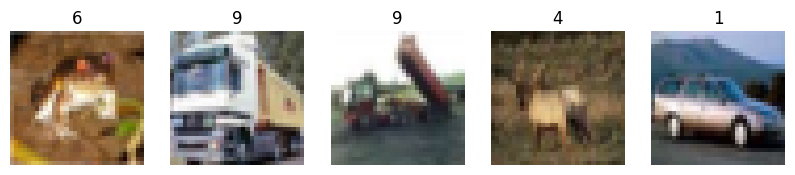

In [ ]:
# Visualize first 5 images
plt.figure(figsize=(10, 2))
for index in range(5):
    plt.subplot(1, 5, index + 1)
    plt.imshow(x_train[index])
    plt.title(y_train[index])
    plt.axis('off')
plt.show()

As we can see, the labels are numeric: to display the class names, let's slightly modify the code.


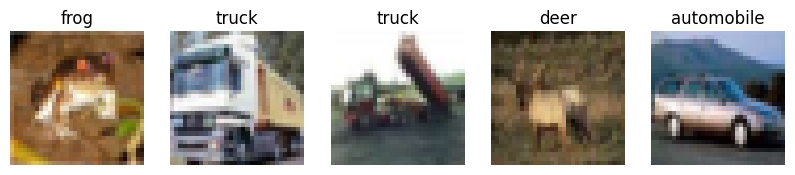

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 2))
for index in range(5):
    plt.subplot(1, 5, index + 1)
    plt.imshow(x_train[index])
    plt.title(class_names[y_train[index]])
    plt.axis('off')
plt.show()


For our CNN model, it needs to recognize cars vs animals. Therefore, we want to take only specific images from each set of data and re-encode them into two classes 'vehicle' and 'animals'

In [ ]:
vehicle_classes = [0, 1, 8, 9]
animal_classes = [2, 3, 4, 5, 6, 7]


# Define a function to filter images
def filter_cars_and_animals(images,labels):
    """
    Takes a batch of images (train or test) and return images of cars and animals.
    In addition, it normalizes the image dividing by 255
    Changes labels in two classes (0=cars,1=animals).
    Args:
        images: images data of each batch
        labels: label data of each batch

    Returns:
       images_filtered: filtered images of cars and animals
       labels_filtered: filtered labels of cars and animals
    """

    mask = np.isin(labels, vehicle_classes + animal_classes)
    images_filtered = images[mask]
    labels_filtered = labels[mask]
    labels_filtered = np.where(np.isin(labels_filtered, vehicle_classes), 0, 1)
    return images_filtered, labels_filtered


image_train, label_train = filter_cars_and_animals(x_train, y_train)
image_test, label_test = filter_cars_and_animals(x_test, y_test)

In [ ]:

## Check Unbalancec classes
print(np.unique(label_train))
unique, counts = np.unique(label_train, return_counts=True)
print(dict(zip(unique, counts)))

[0 1]
{0: 20000, 1: 30000}


### Model training


We will first explore ResNet50 as a base model for transfer learning,
applying it to our custom dataset to leverage its pretrained ImageNet features.


In [ ]:
### Model ResNet50
base_model=ResNet50(weights="imagenet",include_top=False,input_shape=(32, 32, 3))

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation="relu")(x)
x=Dense(1024,activation="relu")(x)
x=Dense(512,activation="relu")(x)
x=Dense(250,activation="relu")(x)
predictions=Dense(1,activation='sigmoid')(x)

In [ ]:
# We train only the last layers
transfer_model=Model(inputs=base_model.input,outputs=predictions)

for layer in transfer_model.layers[:174]:
    layer.trainable=False
for layer in transfer_model.layers[174:]:
    layer.trainable=True

In [ ]:
transfer_model.compile(optimizer="adam",loss='binary_crossentropy',
                       metrics=["accuracy","precision"])

#### Training

In [ ]:
## Preprocess according preprocess of ResNet
train_images_preprocess = preprocess_input(image_train)
test_images_preprocess = preprocess_input(image_test)

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=label_train
)

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 1.25, 1: 0.8333333333333334}


In [ ]:
%%time
history=transfer_model.fit(train_images_preprocess,label_train,batch_size=72,
validation_data=(test_images_preprocess,label_test),epochs=5,
 class_weight=class_weight_dict)

Epoch 1/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 187s 193ms/step - accuracy: 0.8921 - loss: 0.2868 - precision: 0.9294 - val_accuracy: 0.9286 - val_loss: 0.1854 - val_precision: 0.9330
Epoch 2/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 66s 95ms/step - accuracy: 0.9392 - loss: 0.1569 - precision: 0.9634 - val_accuracy: 0.9344 - val_loss: 0.1653 - val_precision: 0.9596
Epoch 3/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 66s 95ms/step - accuracy: 0.9499 - loss: 0.1255 - precision: 0.9695 - val_accuracy: 0.9333 - val_loss: 0.1696 - val_precision: 0.9479
Epoch 4/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 68s 97ms/step - accuracy: 0.9610 - loss: 0.0978 - precision: 0.9782 - val_accuracy: 0.9272 - val_loss: 0.2167 - val_precision: 0.9674
Epoch 5/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 64s 92ms/step - accuracy: 0.9696 - loss: 0.0745 - precision: 0.9850 - val_accuracy: 0.9280 - val_loss: 0.2403 - val_precision: 0.9385
CPU times: user 4min 18s, sys: 59.8 s, total: 5min 18s
Wall time: 7min 33s


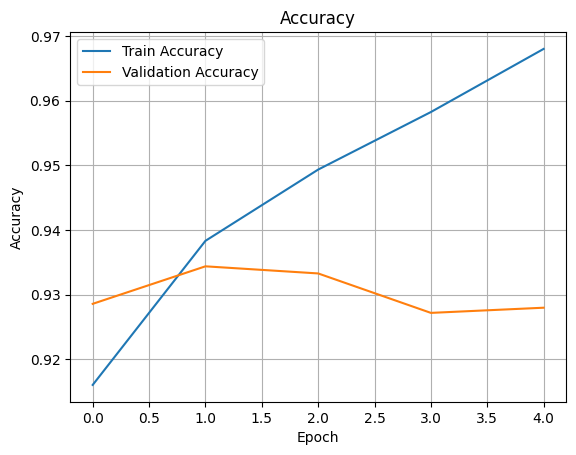

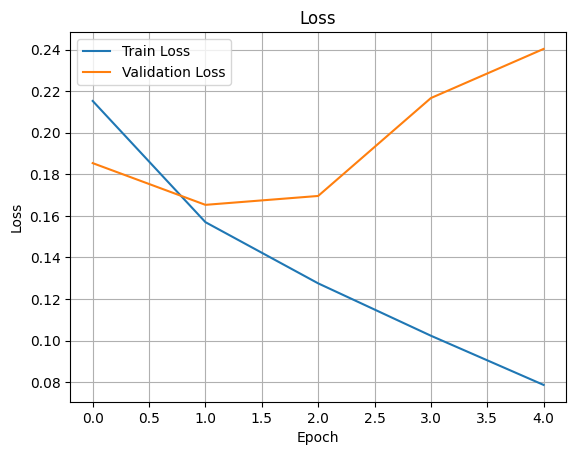

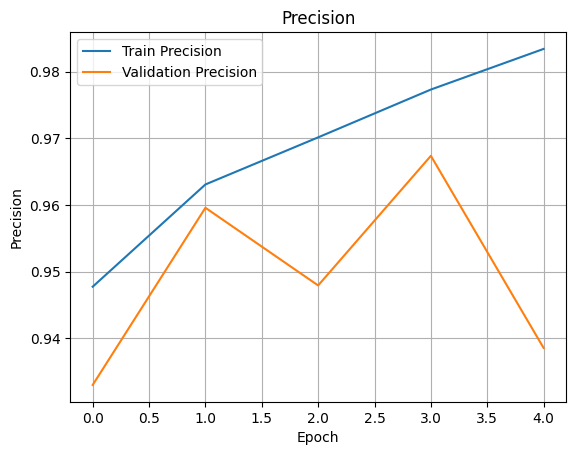

In [ ]:

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Precision
plt.plot(history.history['precision'], label='Train Precision')
if 'val_precision' in history.history:
    plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


The training graphs indicate that the model is overfitting the training data. Over the five epochs, training accuracy, precision, and loss consistently improve, showing that the model is effectively learning patterns within the training set. However, the validation metrics tell a different story—validation accuracy and precision fluctuate without meaningful improvement, and validation loss slightly increases toward the end of training. This divergence between training and validation performance suggests that the model is not generalizing well to unseen data.
We can apply some techniques such as early stopping, regularization to improve the model’s ability to generalize and reduce overfitting.

313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 108ms/step
Precision: 0.9385382059800664
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      4000
           1       0.94      0.94      0.94      6000

    accuracy                           0.93     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



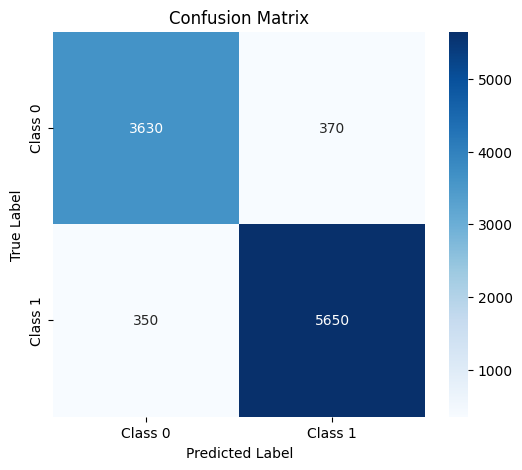

In [ ]:

y_pred_probs = transfer_model.predict(test_images_preprocess)


y_pred_classes = (y_pred_probs > 0.5).flatten()

precision = precision_score(label_test, y_pred_classes, average='binary')
print("Precision:", precision)

print(classification_report(label_test, y_pred_classes))

cm = confusion_matrix(label_test, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Let's try to visualize some images that were misclassified by the model

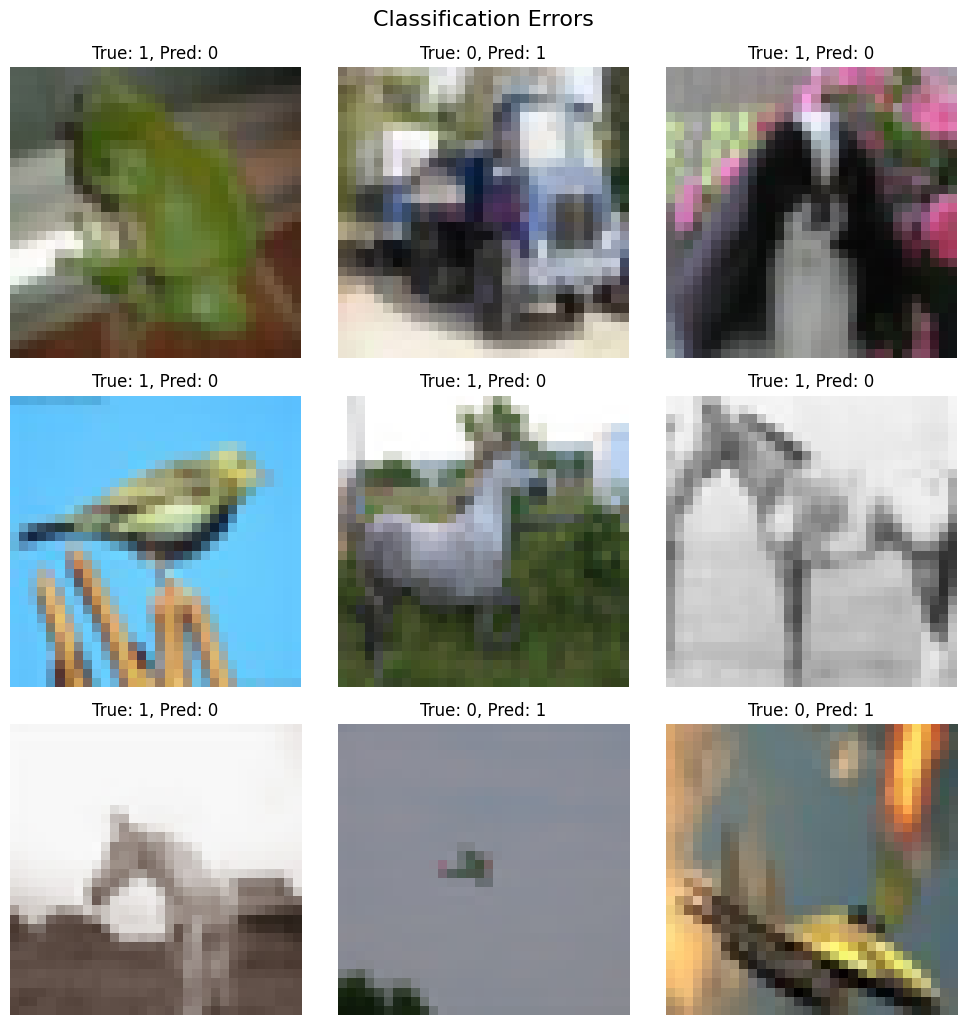

In [ ]:
wrong_indices = np.where(y_pred_classes != label_test)[0]
## Visualize 9 images
num_errors_to_display = min(9, len(wrong_indices))
plt.figure(figsize=(10, 10))

for i, idx in enumerate(wrong_indices[:num_errors_to_display]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image_test[idx])  # Assicurati che test_images sia in formato visualizzabile (es. RGB o grayscale)
    plt.title(f"True: {label_test[idx]}, Pred: {int(y_pred_classes[idx])}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Classification Errors", fontsize=16, y=1.02)
plt.show()

The model makes mistakes by misclassifying animals (especially horses) as vehicles and vice versa. Let's try to modify the model to improve its performance.
We can apply regularization, dropout and early stopping to our model.

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(250, activation="relu", kernel_regularizer=l2(0.001))(x)
predictions = Dense(1, activation='sigmoid')(x)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

transfer_model=Model(inputs=base_model.input,outputs=predictions)
transfer_model.compile(optimizer='adam', loss='binary_crossentropy',
                        metrics=['accuracy','precision'])

for layer in transfer_model.layers[:174]:
    layer.trainable=False
for layer in transfer_model.layers[174:]:
    layer.trainable=True

history = transfer_model.fit(train_images_preprocess,label_train,
                    validation_data=(test_images_preprocess, label_test),
                    epochs=5,
                    callbacks=[early_stop],
                    batch_size=72,
                    class_weight=class_weight_dict)




Epoch 1/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 187s 206ms/step - accuracy: 0.8729 - loss: 2.6929 - precision: 0.9160 - val_accuracy: 0.9196 - val_loss: 0.8490 - val_precision: 0.9529
Epoch 2/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 69s 100ms/step - accuracy: 0.9215 - loss: 0.6816 - precision: 0.9509 - val_accuracy: 0.9190 - val_loss: 0.3908 - val_precision: 0.9535
Epoch 3/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 68s 98ms/step - accuracy: 0.9216 - loss: 0.3707 - precision: 0.9524 - val_accuracy: 0.9227 - val_loss: 0.3028 - val_precision: 0.9494
Epoch 4/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 67s 97ms/step - accuracy: 0.9205 - loss: 0.3049 - precision: 0.9550 - val_accuracy: 0.9243 - val_loss: 0.2829 - val_precision: 0.9565
Epoch 5/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 66s 95ms/step - accuracy: 0.9234 - loss: 0.2829 - precision: 0.9542 - val_accuracy: 0.9231 - val_loss: 0.2717 - val_precision: 0.9546


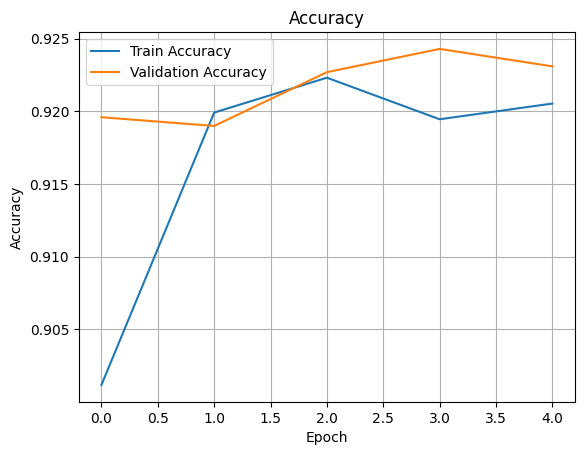

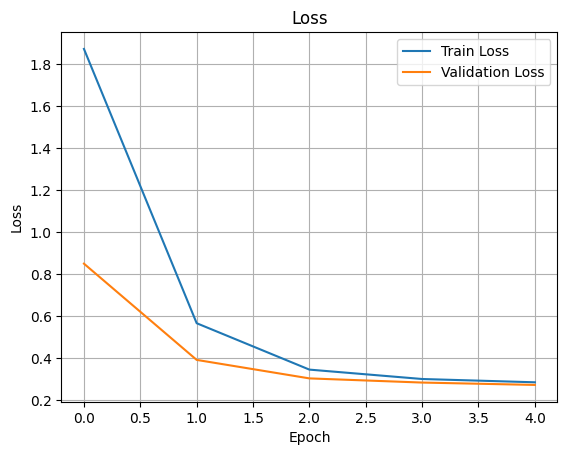

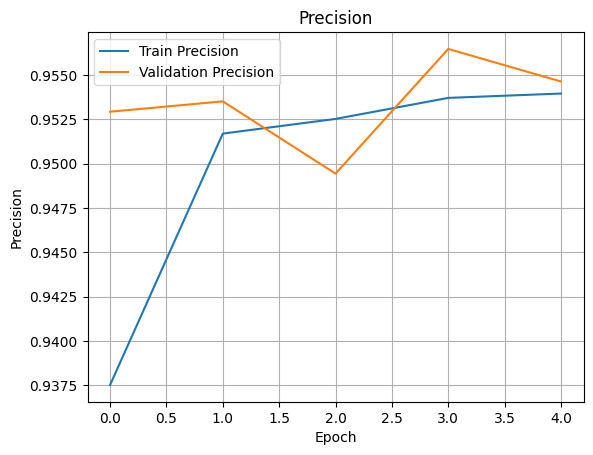

In [ ]:

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Precision
plt.plot(history.history['precision'], label='Train Precision')
if 'val_precision' in history.history:
    plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


The metric plots for the training and validation sets are now more similar, indicating that the model generalizes well to unseen data. However, some images are misclassified, and a few examples are shown below

313/313 ━━━━━━━━━━━━━━━━━━━━ 64s 129ms/step
Precision: 0.9546323657222319
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      4000
           1       0.95      0.92      0.93      6000

    accuracy                           0.92     10000
   macro avg       0.92      0.93      0.92     10000
weighted avg       0.92      0.92      0.92     10000



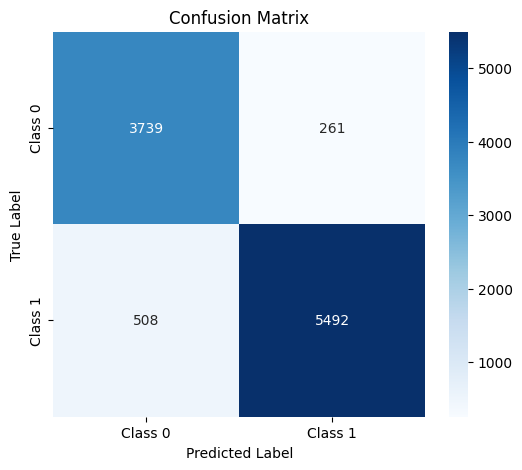

In [ ]:

y_pred_probs = transfer_model.predict(test_images_preprocess)


y_pred_classes = (y_pred_probs > 0.5).flatten()

precision = precision_score(label_test, y_pred_classes, average='binary')
print("Precision:", precision)

print(classification_report(label_test, y_pred_classes))

cm = confusion_matrix(label_test, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


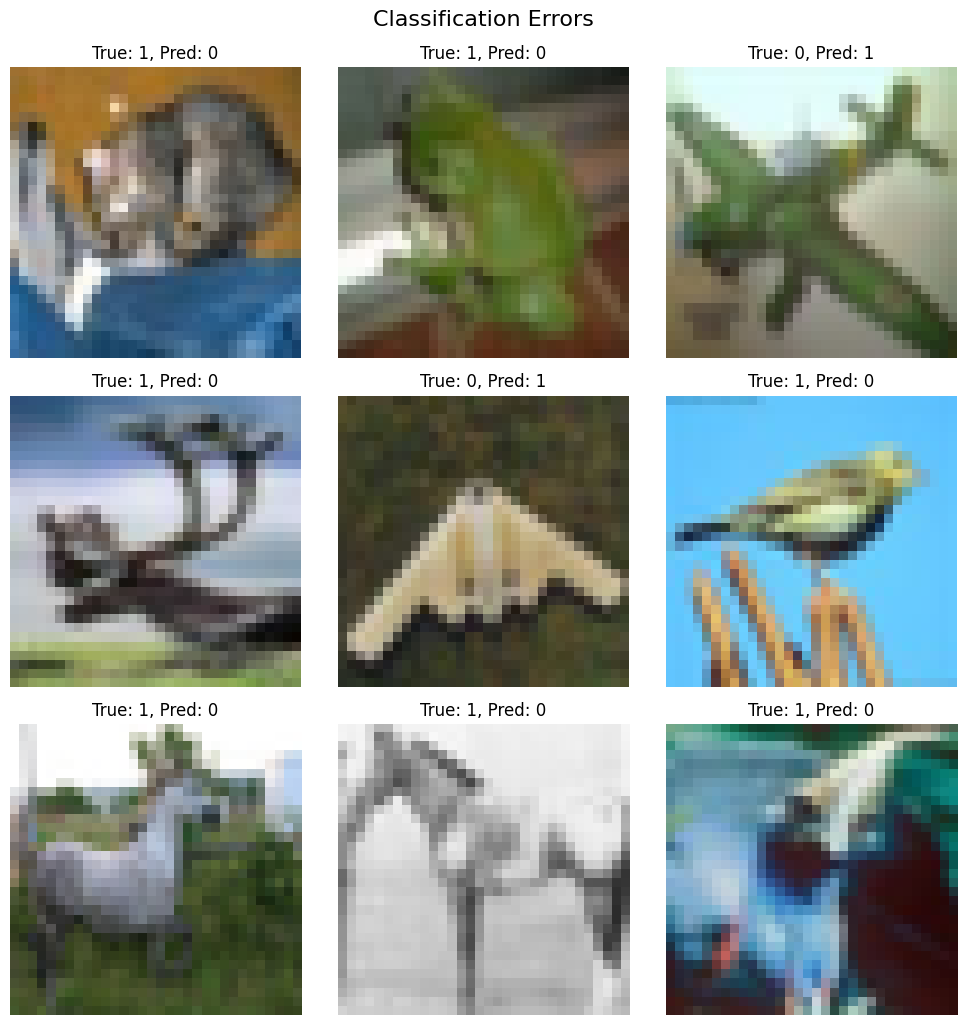

In [ ]:
wrong_indices = np.where(y_pred_classes != label_test)[0]
## Visualize 9 images
num_errors_to_display = min(9, len(wrong_indices))
plt.figure(figsize=(10, 10))

for i, idx in enumerate(wrong_indices[:num_errors_to_display]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image_test[idx])  # Assicurati che test_images sia in formato visualizzabile (es. RGB o grayscale)
    plt.title(f"True: {label_test[idx]}, Pred: {int(y_pred_classes[idx])}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Classification Errors", fontsize=16, y=1.02)
plt.show()